## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

First let us import all the necessary modules required for the entire challenge and load the logins JSON file into a pandas dataframe. Then further examine the dataframe by returning the first 5 rows, the number of rows and columns and their types, and finally some basic statistical metrics on the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense



Using TensorFlow backend.


In [2]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


Now we can rearrange the data into 15 minute intervals adding the count and the day in which the login was recorded.

In [5]:
indexedLogins_df = logins_df.resample("15min",on= "login_time").count()
indexedLogins_df.index.name = 'Login_time'
indexedLogins_df.reset_index(inplace= True)
indexedLogins_df.rename({'login_time':'count'}, axis= 1, inplace= True)
indexedLogins_df.rename({'Login_time':'login_time'}, axis= 1, inplace= True)
indexedLogins_df["day"] = indexedLogins_df['login_time'].dt.day_name()
indexedLogins_df.head()

,login_time,count,day
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


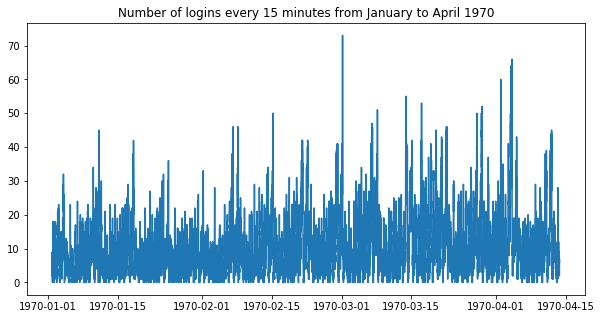

In [6]:
plt.figure(figsize=(10,5))
plt.plot(indexedLogins_df['login_time'],indexedLogins_df['count'])
plt.title('Number of logins every 15 minutes from January to April 1970')
plt.show()

The graph above displays the count of the logins in the dataframe every 15 minutes. We can observe a trend of large peaks every week, in what I would assume are weekends, followed by a dramatic fall in logins at the beginning of each week. We can get a better idea of the number of logins each day by grouping our data by day and graphing it. 

In [7]:
days = indexedLogins_df.sort_values(by= 'day')
days = days.sort_values(by= 'count', ascending= False)
days_count = days[['day','count']]
days_count = days_count.groupby('day').sum().reset_index()
days_count = days_count.reindex([1,5,6,4,0,2,3])

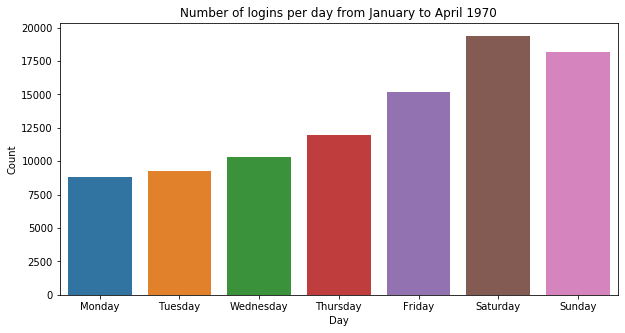

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(x= 'day', y= 'count', data=days_count)
plt.title('Number of logins per day from January to April 1970')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

As predicted earlier we see a steady rise in logins during throughout the week before a large increase in activity on Friday and peaking with Saturday and a slight decrease in logins on Sunday. This can be explained with the demand for taxi rides being larger from Friday evening after most are finished work or classes. Saturdays are when logins peak, not only due to most people having the day off but unlike Sunday do not have work the following day, keeping a large demand for transportation throughout the entire day. Now let us take an even closer look at the trends of data grouping by hours instead of days.

In [9]:
indexedLogins_df['hour'] = indexedLogins_df['login_time'].dt.hour
hours = indexedLogins_df
hours = hours.sort_values(by= 'count', ascending= False)
hours_count = hours[['hour','count']]
hours_count = hours_count.groupby('hour').sum().reset_index()

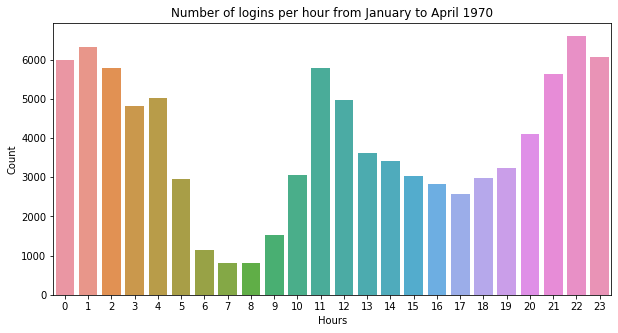

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(x= 'hour', y= 'count', data=hours_count)
plt.title('Number of logins per hour from January to April 1970')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

The graph above displays the trend in logins for each hour of the day. The logins are least frequent around the period of 6 to 9 AM and most frequent from 9 PM to  4 AM. This trend suggests the ridership is lowest during early mornings and business hours with a significant rise from 11-12 which is often the lunch hour most workers receive. The high demand at night could be explained as late-night activities which often include the consumption of alcohol resulting in customers needing safe transportation home in late nights particularly during the weekend. 

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the
    observation
    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

With both cities being most active at different times during the day a reimbursement in toll costs for drivers from either city could provide each city more supply when demand is at its peak and encourage drivers from each city to travel to the other during peak hours. To appropriately conclude that this experiment will indeed yield favourable results, we must compare the data collected before toll reimbursement and after. The key measure of success of this experiment will be an increase in ridership and profits and reduction of waiting time at peak hours for riders. 

The use of A/B testing could be used to evaluate whether the gains of the toll reimbursement prove fruitful to Ultimate as a company. Splitting the drivers randomly into two groups, with one group receiving the toll reimbursement and the other operating as usual. To perform meaningful statistical analysis between the two group data must be collected for a reasonable length of time such as 1-3 months. 

For hypothesis testing for each of our metrics identified earlier the null hypothesis would be that there is no statistically significant difference in the data between the two groups. Once the data is acquired using frequentist inferential statistics and bootstrapping we can simulate further test cases and calculate a p-value and if we get a result larger than 0.05 we can conclude that this is a statistically significant difference. 

Once we identify which of the metrics, if not all, are statistically significant we can conclude whether the experiment improved the service provided by ultimate. The last test would be to compare if the profits gained by the toll reimbursement offsets the extra cost of having to reimburse each driver for their tolls. If the data suggest that the profits do offset the costs of the reimbursement program then all drivers can begin to be compensated for tolls paid after the experiment. If the toll reimbursement does not lead to profits then a return to the regular service can be continued. 

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Similar to the approach taken in Part 1, after loading the JSON file into a pandas dataframe we examine the dataframe using the builtin methods head, info, and describe.

In [11]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


After converting the important date columns into datetime objects, to determine the number users that have used the app in the last 30 days we must first find the last day of data we have. Once that is determined we can filter the user that have taken a trip in the month preceding the last day as user that are active. 

In [14]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [15]:
df['last_trip_date'].sort_values().tail(1) 

45357   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

In [16]:
df['active'] = df['last_trip_date'] >= '2014-06-01'

In [17]:
print('The percentage of users that were retained were {}%'.format(round(sum(df.active)/len(df) * 100),2))

The percentage of users that were retained were 38%


We can observe that the number of users retained were low. Now let us also compare the cities in which data is available to us and determine the number of trips taken during the first 30 days a user has signed up for the service as well as the type of phone the user signed up with.

In [18]:
cities = df[['trips_in_first_30_days','city']].groupby('city').sum().reset_index()

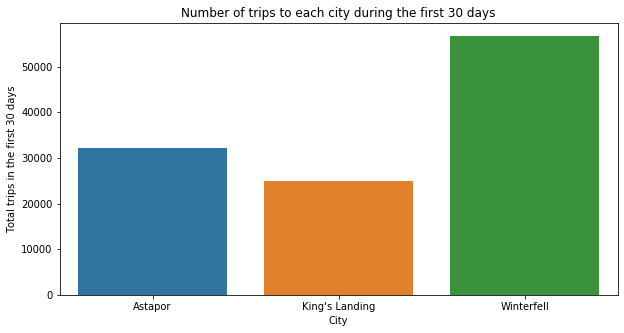

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x= 'city', y= 'trips_in_first_30_days', data= cities)
plt.title('Number of trips to each city during the first 30 days')
plt.xlabel('City')
plt.ylabel('Total trips in the first 30 days')
plt.show()

The graph above indicates that Winterfell was the most popular destination for users who signed up for the app having as many trips as the other two cities combined.

In [20]:
phones = df[['trips_in_first_30_days','phone']].groupby('phone').sum().reset_index()

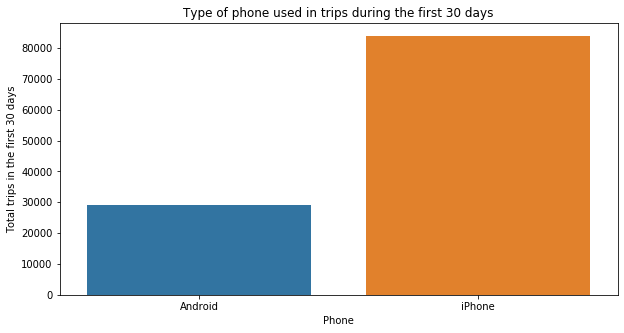

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x= 'phone', y= 'trips_in_first_30_days', data= phones)
plt.title('Type of phone used in trips during the first 30 days')
plt.xlabel('Phone')
plt.ylabel('Total trips in the first 30 days')
plt.show()

The graph above displays the type of phone used by the user in the first 30 days of their signup for the service it is surprising that users were almost 3 times as likely to be using an iPhone then and Android device. Andriod phones have nearly 90 percent of the market share of cellphone usage and so such a difference in users could point to the app on Andriod phones not being as functional as its iOS counterpart. 

To prepare our dataset for modelling there must be some preprocessing of the data that must be performed. Earlier we observed that 3 columns did have null values and these must be filled using the fillna method replacing the null values with the mean of the column. Due to the phone column being either Android or iPhone they were filled using a random selector. 

In [22]:
def fillcol(df,col):
    df[col].fillna(df[col].mean(), inplace= True)

In [23]:
fillcol(df,'avg_rating_by_driver')
fillcol(df,'avg_rating_of_driver')

In [24]:
import random
df['phone'].fillna(random.choice(['iPhone','Andriod']), inplace= True)

In [25]:
df.columns.isnull()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

Now that none of our columns contain null values we must drop columns that are not numerical or significant to our model. We can replace the boolean columns with their integer values and using the pandas method get_dummies we can encode our important columns into numerical columns. 

In [26]:
df = df.drop(columns=['last_trip_date','signup_date'], axis= 1)

In [27]:
df['active'] *= 1

In [28]:
df['ultimate_black_user'] *= 1

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int64  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  active                  50000 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 4.2+ MB


In [30]:
encoded_df = pd.get_dummies(df, columns= ['city','phone'])
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int64  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active                  50000 non-null  int64  
 9   city_Astapor            50000 non-null  uint8  
 10  city_King's Landing     50000 non-null  uint8  
 11  city_Winterfell         50000 non-null  uint8  
 12  phone_Andriod           50000 non-null  uint8  
 13  phone_Android           50000 non-null  uint8  
 14  phone_iPhone            50000 non-null

Now let us store the values of the active column which we will try to predict as the y variable and drop it from the dataset and storing the rest of the values in the X variable. Now we split the data into a training set, which we will use to train the predictive model containing 70 percent of the original data and a test dataset to test its performance on unseen data. We can use StandardScaler to transform the values and scale them for better results.

In [31]:
y = encoded_df['active'].values
df = encoded_df.drop('active', axis= 1 )
X = df.values

In [32]:
X[0]

array([ 4.  ,  4.7 ,  1.1 , 15.4 ,  1.  , 46.2 ,  3.67,  5.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  0.  ,  1.  ])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 13)

In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
X_train[0]

array([ 1.22819526,  0.35310168, -0.34100981, -0.44439259,  1.29186047,
        0.22139868, -0.38063848,  0.04827361, -0.70489569, -0.50468321,
        1.07250799, -0.08899082, -0.65763884,  0.66992196])

The first model we will use to predict the retained users is a logistic regression function from scikit learn. Once we fit the training set we will measure the accuracy on the test set. We will follow that with a random forest classifier from scikit learn and compare the results.

In [36]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
y_pred = lr.predict(X_test)

In [38]:
cm = confusion_matrix(y_test, y_pred)
positive, negative = cm
tp, fp = positive
fn, tn = negative
print('Number of True Positives: {}'.format(tp))
print('Number of True Negatives: {}'.format(tn))
print('Number of False Positives: {}'.format(fp))
print('Number of False Negatives: {}'.format(fn))

Number of True Positives: 7984
Number of True Negatives: 2830
Number of False Positives: 1407
Number of False Negatives: 2779


In [39]:
acc = metrics.accuracy_score(y_test, y_pred)
print('Model Accuracy: {} %'.format(round(acc*100,2)))

Model Accuracy: 72.09 %


In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
y_pred2 = rf.predict(X_test)

In [42]:
cm2 = confusion_matrix(y_test, y_pred2)
positive2, negative2 = cm2
tp2, fp2 = positive2
fn2, tn2 = negative2
print('Number of True Positives: {}'.format(tp2))
print('Number of True Negatives: {}'.format(tn2))
print('Number of False Positives: {}'.format(fp2))
print('Number of False Negatives: {}'.format(fn2))

Number of True Positives: 7669
Number of True Negatives: 3791
Number of False Positives: 1722
Number of False Negatives: 1818


In [43]:
acc2 = metrics.accuracy_score(y_test, y_pred2)
print('Model Accuracy: {}%'.format(round(acc2*100,2)))

Model Accuracy: 76.4%


While both the logitistic regression and random forest classifer perform admirably let us now use the deep learning library of keras to built a simple neural network of 3 hidden layers with 6 neurons (half of the number of inputs) using the rectified linear unit (ReLU) activation function to return a prediction of wether a user will be retained or not. We will use the adam optimizer and binary crossentropy as our probablistic loss and return the accuracy from a batch size of 20 for 20 epochs.

In [44]:
clf = Sequential()

In [45]:
clf.add(Dense(units= 6, activation= 'relu', kernel_initializer= 'uniform'))
clf.add(Dense(units= 6, activation= 'relu', kernel_initializer= 'uniform'))
clf.add(Dense(units= 6, activation= 'relu', kernel_initializer= 'uniform'))
clf.add(Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'uniform'))

In [46]:
clf.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [47]:
clf.fit(X_train, y_train, batch_size= 20, epochs= 20)

Epoch 1/20
35000/35000 [==============================] - 4s 111us/step - loss: 0.5566 - accuracy: 0.7199
Epoch 2/20
35000/35000 [==============================] - 3s 96us/step - loss: 0.5109 - accuracy: 0.7537
Epoch 3/20
35000/35000 [==============================] - 3s 94us/step - loss: 0.4992 - accuracy: 0.7625
Epoch 4/20
35000/35000 [==============================] - 4s 105us/step - loss: 0.4968 - accuracy: 0.7656
Epoch 5/20
35000/35000 [==============================] - 4s 102us/step - loss: 0.4952 - accuracy: 0.7663
Epoch 6/20
35000/35000 [==============================] - 4s 105us/step - loss: 0.4947 - accuracy: 0.7663
Epoch 7/20
35000/35000 [==============================] - 4s 105us/step - loss: 0.4940 - accuracy: 0.7668
Epoch 8/20
35000/35000 [==============================] - 3s 94us/step - loss: 0.4935 - accuracy: 0.7666
Epoch 9/20
35000/35000 [==============================] - 3s 95us/step - loss: 0.4926 - accuracy: 0.7679
Epoch 10/20
35000/35000 [=========================

In [48]:
y_pred3 = clf.predict(X_test)

In [49]:
y_pred4 = y_pred3 > 0.5

In [50]:
cm4 = confusion_matrix(y_test, y_pred4)
positive4, negative4 = cm4
tp4, fp4 = positive4
fn4, tn4 = negative4
print('Number of True Positives: {}'.format(tp4))
print('Number of True Negatives: {}'.format(tn4))
print('Number of False Positives: {}'.format(fp4))
print('Number of False Negatives: {}'.format(fn4))

Number of True Positives: 7872
Number of True Negatives: 3802
Number of False Positives: 1519
Number of False Negatives: 1807


In [51]:
acc3 = metrics.accuracy_score(y_test, y_pred4)
print('Model Accuracy: {}%'.format(round(acc3*100,2)))

Model Accuracy: 77.83%


The neural network returns the best accuracy of all the models tested so far now let us use it to predict on the test data and assign all predictions above 50 percent(other thresholds close to 50 were tested but yielded inferior results) and using the confusion matrix from scikit learn to examine the number of True and False prediction both positive and negative. We returned far fewer false positive than false negatives which in this instance is preferable as overpredicting the number of users retained can be far more harmful than underpredicting. That is what truly makes the final model better than the random forest classifier despite relatively close accuracy between the two. While the predictive model performs admirably the next step would be to design a neural network using TensorFlow and optimize performance through tuning all the hyperparameters involved in the neural network.